<h1><center>Lab 3 - A3</center></h1>

In [23]:
import time
import math
import random
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

# Tabu search algorithm
Pseudocode:
```
c = initSolution()
best = c
M = initMemory()

while (stop-criterion not met)
    x = getBestNeighbourNonTabu(c)
    updateMemory()
    c = x
    update best

return best
```
In what follows, we will use the tabu search algorithm to solve 2 problems, the knapsack problem and the travelling salesman problem (TSP).

# Knapsack Problem
- $n$ objects, each has a value ($v$) and a weight ($w$)
- Objective: the knapsack to contain max value without exceeding max weight $W$
$$ \text{maximise } \sum_{i=n}^n v_i x_i $$
$$ \text{subject to } \sum_{i=n}^n v=w_i x_i \leq W  $$
- $x_i=1$ means object $i$ is selected
- $x_i=0$ means object $j$ is not selected

## Knapsack problem: prerequisites
Helper functions for knapsack solution generation and evaluation

In [2]:
# Data loading function

def load_data(file_name):
  '''
    Loads data for the knapsack problem from a file
    Input:
      - file_name: str
    Output:
      - n: int
      - weights_and_values: list[tuple[int, int]]
      - max_weight: int
  '''
  weights_and_values = []
  with open(file_name) as f:
    # first number = number of records
    size = (int)(f.readline().strip())
    # read index, value, weight for all records
    for i in range(size):
      info = f.readline().strip().split()
      index, value, weight = (int)(info[0]), (int)(info[1]), (int)(info[2])
      weights_and_values.append((weight, value))
    # last number = maximum weight
    max_weight = (int)(f.readline().strip())
  return size, weights_and_values, max_weight

In [3]:
# Knapsack solution evaluation functions

def knapsack_weight(n, weights_and_values, configuration):
  '''
    Returns the total weight of the knapsack for a certain configuration
    Input:
      - n: int
      - weights_and_values: list[tuple[int, int]]
      - configuration: list[{0,1}] -> size = n
    Output:
      - weight: int
  '''
  weight = 0
  for i in range(n):
    if configuration[i] == 1:
      curr_weight, curr_value = weights_and_values[i]
      weight += curr_weight
  return weight

def knapsack_value(n, weights_and_values, configuration):
  '''
    Returns the total value of the knapsack for a certain configuration
    Input:
      - n: int
      - weights_and_values: list[tuple[int, int]]
      - configuration: list[{0,1}] -> size = n
    Output:
      - value: int
  '''
  value = 0
  for i in range(n):
    if configuration[i] == 1:
      curr_weight, curr_value = weights_and_values[i]
      value += curr_value
  return value

def knapsack_is_valid(n, weights_and_values, configuration, max_weight):
  '''
    Checks if a certain knapsack configuration is a valid solution
    Input:
      - n: int
      - weights_and_values: list[tuple[int, int]]
      - configuration: list[{0,1}] -> size = n
      - max_weight: int
    Output:
      - bool
  '''
  weight = knapsack_weight(n, weights_and_values, configuration)
  return weight <= max_weight

def knapsack_fitness(n, weights_and_values, configuration, max_weight):
  '''
    Returns the total value of the knapsack for a certain configuration if it is valid
      or -1 if it is not valid
    Input:
      - n: int
      - weights_and_values: list[tuple[int, int]]
      - configuration: list[{0,1}] -> size = n
    Output:
      - fitness: int
  '''
  if not knapsack_is_valid(n, weights_and_values, configuration, max_weight):
    return -1
  return knapsack_value(n, weights_and_values, configuration)

In [4]:
# Random knapsack solutions generation functions

def generate_random_configuration(n):
  '''
    Generate a random binary list of size n
    Input:
      - n: int
    Output:
      - list[{0,1}] -> size = n
  '''
  return np.random.randint(2, size=n).tolist()

def generate_random_knapsack(n, weights_and_values, max_weight):
  '''
    Generates a random knapsack configuration and computes its weight, value and fitness
    Input:
      - n: int
      - weights_and_values: list[tuple[int, int]]
      - max_weight: int
    Output:
      - configuration: list[{0,1}] -> size = n
      - weight: int
      - value: int
      - fitness: int
  '''
  configuration = generate_random_configuration(n)
  weight = knapsack_weight(n, weights_and_values, configuration)
  value = knapsack_value(n, weights_and_values, configuration)
  fitness = knapsack_fitness(n, weights_and_values, configuration, max_weight)
  return configuration, weight, value, fitness

def generate_random_valid_knapsack(n, weights_and_values, max_weight):
  '''
    Generates random knapsack configurations until it finds a valid one
    Input:
      - n: int
      - weights_and_values: list[tuple[int, int]]
      - max_weight: int
    Output:
      - configuration: list[{0,1}] -> size = n
      - weight: int
      - value: int
      - fitness: int
  '''
  while True:
    configuration, weight, value, fitness = generate_random_knapsack(n, weights_and_values, max_weight)
    if fitness > 0:
      break
  return configuration, weight, value, fitness

In [5]:
# Display functions

def print_knapsack_solution(n, weights_and_values, max_weight, configuration):
  '''
    Prints a solution of a given knapsack problem
    Input:
      - n: int
      - weights_and_values: list[tuple[int, int]]
      - max_weight: int
      - configuration: list[{0,1}] -> size = n
    Output: None
  '''
  weight = knapsack_weight(n, weights_and_values, configuration)
  value = knapsack_value(n, weights_and_values, configuration)
  fitness = knapsack_fitness(n, weights_and_values, configuration, max_weight)
  print(f"Solution for knapsack problem of size {n} with max weight {max_weight}:")
  print(f"Configuration: {configuration}")
  print(f"Weight: {weight}; Value: {value}")
  print(f"Fitness: {fitness}")

def lists_to_markdown_table(header, *lists):
  '''
    Returns a string formatted like a markdown table which contains data from the header and the lists
    Input:
      - header: string
      - *lists: varying number of list[] -> size = n
    Output:
      - markdown_table: string
  '''
  markdown_table = header
  n = len(lists[0])
  for i in range(n):
    markdown_table += "|"
    for list in lists:
      markdown_table += f" {list[i]} |"
    markdown_table += "\n"
  return markdown_table

## Tabu search for the knapsack problem

### Implementation

In [9]:
# Helper functions to TS for the knapsack problem

def flip(configuration, flip_position):
  '''
    Flips the node found at position i in the given configuration
    Input:
      - configuration: list[{0,1}]
      - flip_position: int
    Output:
      - new_configuration: list[{0,1}]
  '''
  new_configuration = configuration[:]
  if new_configuration[flip_position] == 0:
    new_configuration[flip_position] = 1
  else:
    new_configuration[flip_position] = 0
  return new_configuration

def best_flip_memory(n, weights_and_values, max_weight, configuration, memory):
  '''
    Returns the one-bit mutant of the current configuration which yields the best fitness increase and is not already in memory or the zero vector if there is no such configuration
    Input:
      - n: int
      - weights_and_values: list[tuple[int, int]]
      - max_weight: int
      - configuration: list[{0,1}] -> size = n
      - memory: list[list[{0,1}]]
    Output:
      - new_configuration: list[{0,1}] -> size = n
  '''
  new_configuration = [0 for _ in range(n)]
  # initialize best fitness with current fitness
  best_fitness = knapsack_fitness(n, weights_and_values, configuration, max_weight)
  # find all mutants, calculate their fitness and check if they are in memory
  for i in range(n):
    mutant_configuration = flip(configuration, i)
    if mutant_configuration not in memory:
      mutant_fitness = knapsack_fitness(n, weights_and_values, mutant_configuration, max_weight)
      if mutant_fitness > best_fitness:
        best_fitness = mutant_fitness
        new_configuration = mutant_configuration
  return new_configuration

In [12]:
# Tabu search algorithm for solving the knapsack problem

def knapsack_tabu_search(max_iterations, max_memory, n, weights_and_values, max_weight):
  '''
    Implements a tabu search algorithm for the knapsack problem
    Checks for improvements by flipping bits in the configuration and chooses the best improvement
      this is done a total number of max_iterations
    It keeps track of the configurations already visited using memory
      the memory has a size given by max_memory
      if it is full, then last seen configurations are discarded
    Input:
      - max_iterations: int
      - max_memory: int
      - n: int
      - weights_and_values: list[tuple[int, int]]
      - max_weight: int
    Output:
      - best_configuration: list[{0,1}]
  '''
  # initialize best configuration and memory
  current_configuration = generate_random_configuration(n)
  current_fitness = knapsack_fitness(n, weights_and_values, current_configuration, max_weight)
  memory = [current_configuration]
  # initialize count
  count = 0
  while count < max_iterations:
    new_configuration = best_flip_memory(n, weights_and_values, max_weight, current_configuration, memory)
    # check if new configuration increases fitness
    if knapsack_fitness(n, weights_and_values, new_configuration, max_weight) > current_fitness:
        # update current configuration and memory
        current_configuration = new_configuration
        current_fitness = knapsack_fitness(n, weights_and_values, new_configuration, max_weight)
        memory.append(new_configuration)
    # clear memory if necessary
    if len(memory) == max_memory:
        memory = memory[1:]
    # update count
    count += 1
  return current_configuration


### Testing

In [17]:
# Testing the tabu search algorithm for different values of n, max_iterations and max_memory

n, weights_and_values, max_weight = load_data("C:/Users/Elena/OneDrive - Universitatea Babeş-Bolyai/AI UBB - Semester 4/Metaheuristics/Labs/lab1/input_files/knapsack-20.txt")

max_iterations = 1000
max_memory = 400
start_time = time.time()
configuration = knapsack_tabu_search(max_iterations, max_memory, n, weights_and_values, max_weight)
end_time = time.time()

print(f"Maximum number of iterations: {max_iterations}")
print(f"Maximum memory: {max_memory}\n")
print_knapsack_solution(n, weights_and_values, max_weight, configuration)
print(f"\nExecution time: {end_time - start_time}\n")

n, weights_and_values, max_weight = load_data("C:/Users/Elena/OneDrive - Universitatea Babeş-Bolyai/AI UBB - Semester 4/Metaheuristics/Labs/lab1/input_files/rucsac-200.txt")

max_iterations = 500
max_memory = 200
start_time = time.time()
configuration = knapsack_tabu_search(max_iterations, max_memory, n, weights_and_values, max_weight)
end_time = time.time()

print(f"Maximum number of iterations: {max_iterations}")
print(f"Maximum memory: {max_memory}\n")
print_knapsack_solution(n, weights_and_values, max_weight, configuration)
print(f"\nExecution time: {end_time - start_time}\n")


Maximum number of iterations: 1000
Maximum memory: 400

Solution for knapsack problem of size 20 with max weight 524:
Configuration: [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1]
Weight: 520; Value: 673
Fitness: 673

Execution time: 0.061400651931762695

Maximum number of iterations: 500
Maximum memory: 200

Solution for knapsack problem of size 200 with max weight 112648:
Configuration: [0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,

# Travelling Salesman Problem (TSP)
Given a collection of N cities and the cost of travel between each pair of them, the **traveling salesman problem**, or TSP for short, is to find the cheapest way of visiting all of the cities and returning to your starting point.
  
In the standard version, the travel costs are symmetric in the sense that traveling from city X to city Y costs just as much as traveling from Y to X.
  
The solution can be represented as permutation of size N. The cost of a solution is the sum of distances
between cities in the order given by the permutation.

## Travelling Salesman Problem: prerequisites
Helper functions for TSP solution generation and evaluation

In [18]:
# Data loading function

def load_data(file_name):
  '''
    Loads data for TSP from a file (extension .tsp)
    Input:
      - file_name: str
    Output:
      - n: int
      - nodes: dict[int]: tuple[int, int]
  '''
  n = 0
  nodes = {}
  with open(file_name) as f:
    while True:
      line = f.readline()
      # line at beginning of file
      if line[0] >= 'A' and line[0] <= 'Z':
        # get size of dataset
        if line.split()[0] == 'DIMENSION':
          n = int(line.split()[2])
        # end of file
        elif line.strip() == 'EOF':
          break
        else:
          continue
      # line containing tsp data
      else:
        i, x, y = line.split()
        i = int(i)
        x = float(x)
        y = float(y)
        nodes[i] = (x, y)
  return n, nodes

# test function
load_data("C:/Users/Elena/OneDrive - Universitatea Babeş-Bolyai/AI UBB - Semester 4/Metaheuristics/Labs/lab3/input_files/eil101.tsp")

(101,
 {1: (41.0, 49.0),
  2: (35.0, 17.0),
  3: (55.0, 45.0),
  4: (55.0, 20.0),
  5: (15.0, 30.0),
  6: (25.0, 30.0),
  7: (20.0, 50.0),
  8: (10.0, 43.0),
  9: (55.0, 60.0),
  10: (30.0, 60.0),
  11: (20.0, 65.0),
  12: (50.0, 35.0),
  13: (30.0, 25.0),
  14: (15.0, 10.0),
  15: (30.0, 5.0),
  16: (10.0, 20.0),
  17: (5.0, 30.0),
  18: (20.0, 40.0),
  19: (15.0, 60.0),
  20: (45.0, 65.0),
  21: (45.0, 20.0),
  22: (45.0, 10.0),
  23: (55.0, 5.0),
  24: (65.0, 35.0),
  25: (65.0, 20.0),
  26: (45.0, 30.0),
  27: (35.0, 40.0),
  28: (41.0, 37.0),
  29: (64.0, 42.0),
  30: (40.0, 60.0),
  31: (31.0, 52.0),
  32: (35.0, 69.0),
  33: (53.0, 52.0),
  34: (65.0, 55.0),
  35: (63.0, 65.0),
  36: (2.0, 60.0),
  37: (20.0, 20.0),
  38: (5.0, 5.0),
  39: (60.0, 12.0),
  40: (40.0, 25.0),
  41: (42.0, 7.0),
  42: (24.0, 12.0),
  43: (23.0, 3.0),
  44: (11.0, 14.0),
  45: (6.0, 38.0),
  46: (2.0, 48.0),
  47: (8.0, 56.0),
  48: (13.0, 52.0),
  49: (6.0, 68.0),
  50: (47.0, 47.0),
  51: (49.0, 58

In [48]:
# Utility functions

def euclidean_distance(x, y):
  '''
    Computes the euclidean distance between two points in 2D space
    Input:
      - x: tuple[int, int]
      - y: tuple[int, int]
    Output:
      - float
  '''
  return math.sqrt((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2)

In [82]:
# TSP evaluation functions
def tsp_fitness(n, nodes, permutation):
  '''
    Calculates the total length of the tour described by the permutation
    Input:
      - n: int
      - nodes: dict[int]: tuple[int, int]
      - permutation: list[int] -> size = n
    Output:
      - length: float
  '''
  length = 0
  for i in range(n - 1):
    length += euclidean_distance(nodes[permutation[i]], nodes[permutation[i+1]])
  length += euclidean_distance(nodes[permutation[-1]], nodes[permutation[0]])
  return length

In [89]:
# TSP generation functions
def generate_random_permutation(n):
  '''
    Generates a random permutation of size n
    Input:
      - n: int
    Output:
      - permutation: list[int] -> size = n
  '''
  permutation = [(1 + i) for i in range(n)]
  random.shuffle(permutation)  
  return permutation

In [148]:
# Visualizing data

def plot_tsp(nodes, configuration):
  '''
    Plots a TSP tour with matplotlib
    Input: 
      - nodes: dict[int]: tuple[int, int]
      - configuration: list[tuple[int, int]]
    Output: None
  '''
  x = [nodes[i][0] for i in configuration]
  x.append(x[0])

  y = [nodes[i][1] for i in configuration]
  y.append(y[0])

  plt.plot(x, y, marker='o', linestyle='-', markersize=8)
  plt.grid()
  plt.show()

def thin_plot_tsp(nodes, configuration):
  '''
    Plots a TSP tour with matplotlib (uses thin lines and no markers) - good for visualizing big datasets
    Input: 
      - nodes: dict[int]: tuple[int, int]
      - configuration: list[tuple[int, int]]
    Output: None
  '''
  x = [nodes[i][0] for i in configuration]
  x.append(x[0])

  y = [nodes[i][1] for i in configuration]
  y.append(y[0])

  plt.plot(x, y, linestyle='-')
  plt.grid()
  plt.show()

## Greedy approach to TSP
1. Choose a random starting point. Add it to the list of visited nodes.
2. Calculate the closest point which has not been visited and set it as current point. Adjust the list of visited nodes accordingly.
3. Repeat step 2 until there are no more nodes left to visit.

### Implementation

In [133]:
# Helper functions to Greddy algorithm for TSP

def closest_unvisited_neighbour(current_node, nodes, visited_nodes):
  '''
    Returns the closest node to current which has not been visited yet
    Input:
      - current_node: tuple[int, int]
      - nodes: dict[int]: tuple[int, int]
      - visited_nodes: list[tuple[int, int]]
    Output:
      - closest_neighbour: tuple[int, int]
  '''
  closest_neighbour = current_node
  min_distance = float('inf')
  # visit nodes sequentially
  count = 0
  for neighbor in nodes.keys():
    if neighbor not in visited_nodes:
      # calculate distance between current node and neighbour
      distance = euclidean_distance(nodes[current_node], nodes[neighbor])
      if distance < min_distance:
        min_distance = distance
        closest_neighbour = neighbor
      count += 1
      if count > 100:
        break
  return closest_neighbour, min_distance

In [135]:
# Greedy algorithm for solving the travelling salesman problem

def tsp_greedy(n, nodes):
  '''
    Generates a greedy solution for TSP choosing closest neighbors at every step
    Input:
      - n: int
      - nodes: dict[int]: tuple[int, int]
    Output:
      - length: float
  '''
  length = 0
  current_node = np.random.randint(1, n)
  visited_nodes = [current_node]
  
  while len(visited_nodes) < n:
    closest_neighbour, min_distance = closest_unvisited_neighbour(current_node, nodes, visited_nodes)
    current_node = closest_neighbour
    visited_nodes.append(closest_neighbour)
    length += min_distance
  # add distance between the last and first node to length
  length += euclidean_distance(nodes[current_node], nodes[visited_nodes[0]])
  return length

def tsp_greedy_m_times(m, n, nodes):
  '''
    Runs the greedy algorithm for the tsp problem m times and returns the best solutions found
    Input:
      - m: int
      - n: int
      - nodes: dict[int]: tuple[int, int]
    Output:
      - best_solutions: list[float]
  '''
  best_solutions = []
  for step in range(m):
    best_evaluated = tsp_greedy(n, nodes)
    best_solutions.append(best_evaluated)
  return best_solutions

### Testing

In [139]:
# Testing the greedy algorithm to TSP

# n = 101
n, nodes = load_data("C:/Users/Elena/OneDrive - Universitatea Babeş-Bolyai/AI UBB - Semester 4/Metaheuristics/Labs/lab3/input_files/eil101.tsp")

length = tsp_greedy(n, nodes)

print(f"Solution to TSP for {n} nodes:")
print(f"Fitness: {length}")

# n = 9152
n, nodes = load_data("C:/Users/Elena/OneDrive - Universitatea Babeş-Bolyai/AI UBB - Semester 4/Metaheuristics/Labs/lab3/input_files/ar9152.tsp")

# length = tsp_greedy(n, nodes)
# print(f"Solution to TSP for {n} nodes:")
# print(f"Fitness: {length}")

Solution to TSP for 101 nodes:
Fitness: 776.5184013198424


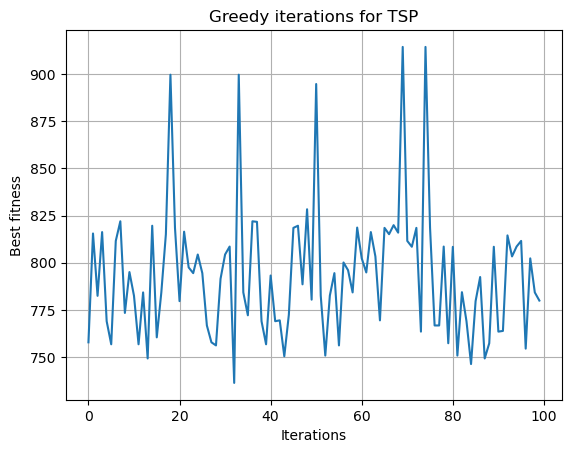

In [100]:
# Running multiple iterations of greedy algorithm to tsp

# n = 101
n, nodes = load_data("C:/Users/Elena/OneDrive - Universitatea Babeş-Bolyai/AI UBB - Semester 4/Metaheuristics/Labs/lab3/input_files/eil101.tsp")

# test Greedy on 100 iterations
iterations = 100
best_fitnesses = tsp_greedy_m_times(iterations, n, nodes)

# plot data
plt.plot(best_fitnesses)
plt.grid()
plt.xlabel("Iterations")
plt.ylabel("Best fitness")
plt.title("Greedy iterations for TSP")
plt.show()

## Tabu search for TSP

### Implementation

In [145]:
# Helper functions to Tabu search algorithm for TSP

def swap(permutation, swap_position_1, swap_position_2):
  '''
    Swaps two nodes at the specified positions in the given permutation
    Input:
      - permutation: list[int]
      - swap_position_1: int
      - swap_position_2: int
    Output:
      - new_permutation: list[int]
  '''
  new_permutation = permutation[:]
  new_permutation[swap_position_1] = permutation[swap_position_2]
  new_permutation[swap_position_2] = permutation[swap_position_1]
  return new_permutation

def best_swap_memory(n, nodes, permutation, max_neighbours=500):
  '''
    Returns the swap of the current permutation which yields the best fitness increase and is not already in memory or the zero vector if there is no such configuration
    Input:
      - n: int
      - nodes: dict[int]: tuple[int, int]
      - permutation: list[int] -> size = n
      - max_neighbours: int (default value = 500)
    Output:
      - new_permutation: list[int] -> size = n
  '''
  new_permutation = permutation[:]
  # initialize best fitness with current fitness
  best_fitness = tsp_fitness(n, nodes, permutation)
  # find all swaps, calculate their fitness and check if they are in memory
  if n < 100:
    # generate all pairs
    for i in range(n):
      for j in range(i + 1, n):
        swap_permutation = swap(permutation, i, j)
        swap_fitness = tsp_fitness(n, nodes, swap_permutation)
        if swap_fitness < best_fitness:
          best_fitness = swap_fitness
          new_permutation = swap_permutation
  else:
    for _ in range(max_neighbours):
      # pick 2 random indicies
      i, j = random.sample(range(n), 2)
      # ensure order
      if i > j:
        i, j = j, i
      # check swap permutation
      swap_permutation = swap(permutation, i, j)
      swap_fitness = tsp_fitness(n, nodes, swap_permutation)
      if swap_fitness < best_fitness:
        best_fitness = swap_fitness
        new_permutation = swap_permutation
  return new_permutation

In [141]:
# Tabu search algorithm for solving the travelling salesman problem

def tsp_tabu_search(max_iterations, max_memory, n, nodes):
  '''
    Implements a tabu search algorithm for the travelling salesman problem
    Checks for improvements by swapping nodes in the configuration and chooses the best improvement
      this is done a total number of max_iterations
    It keeps track of the configurations already visited using memory
      the memory has a size given by max_memory
      if it is full, then last seen configurations are discarded
    Input:
      - max_iterations: int
      - max_memory: int
      - n: int
      - nodes: dict[int]: tuple[int, int]
    Output:
      - best_configuration: list[int]
  '''
  # initialize best configuration and memory
  current_configuration = generate_random_permutation(n)
  current_fitness = tsp_fitness(n, nodes, current_configuration)
  memory = [current_configuration]
  # initialize count
  count = 0
  while count < max_iterations:
    new_configuration = best_swap_memory(n, nodes, current_configuration)
    # check if new configuration increases fitness
    if tsp_fitness(n, nodes, new_configuration) < current_fitness:
        # update current configuration and memory
        current_configuration = new_configuration
        current_fitness = tsp_fitness(n, nodes, new_configuration)
        memory.append(new_configuration)
    # clear memory if necessary
    if len(memory) == max_memory:
        memory = memory[1:]
    # update count
    count += 1
  return current_configuration


### Testing

Solution to TSP for 101 nodes
With parameters: max. iterations 20, max. memory 50:
Fitness: 1930.9912382377015
Route found:


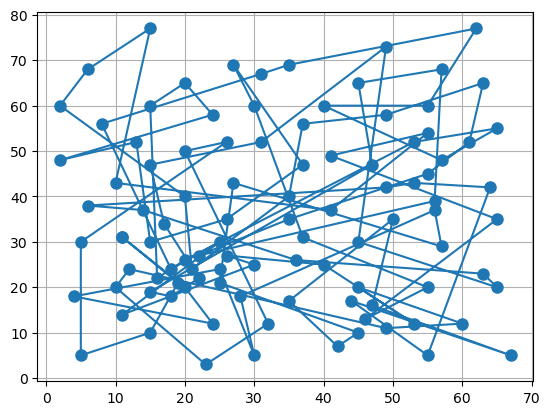

Solution to TSP for 101 nodes
With parameters: max. iterations 100, max. memory 100:
Fitness: 1057.4790411084487
Route found:


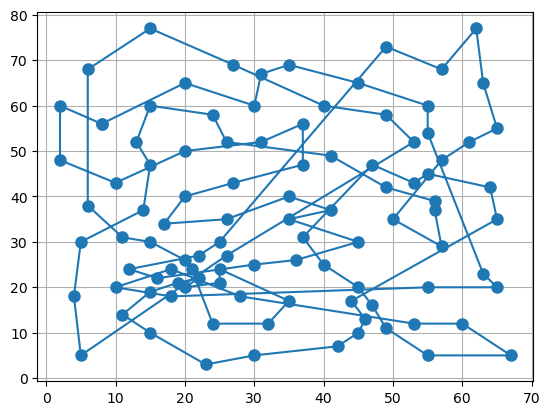

Solution to TSP for 101 nodes
With parameters: max. iterations 1000, max. memory 100:
Fitness: 950.3758786739887
Route found:


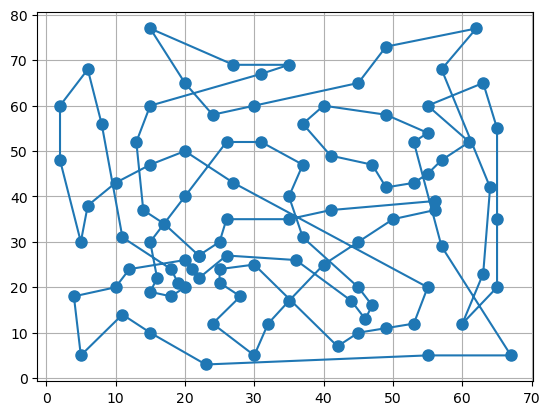

In [152]:
# Testing tabu search on TSP

# n = 101
n, nodes = load_data("C:/Users/Elena/OneDrive - Universitatea Babeş-Bolyai/AI UBB - Semester 4/Metaheuristics/Labs/lab3/input_files/eil101.tsp")

max_iterations = 20
max_memory = 50

configuration = tsp_tabu_search(max_iterations, max_memory, n, nodes)
fitness = tsp_fitness(n, nodes, configuration)

print(f"Solution to TSP for {n} nodes")
print(f"With parameters: max. iterations {max_iterations}, max. memory {max_memory}:")
print(f"Fitness: {fitness}")

print("Route found:")
plot_tsp(nodes, configuration)

max_iterations = 100
max_memory = 100

configuration = tsp_tabu_search(max_iterations, max_memory, n, nodes)
fitness = tsp_fitness(n, nodes, configuration)

print(f"Solution to TSP for {n} nodes")
print(f"With parameters: max. iterations {max_iterations}, max. memory {max_memory}:")
print(f"Fitness: {fitness}")

print("Route found:")
plot_tsp(nodes, configuration)

max_iterations = 1000
max_memory = 100

configuration = tsp_tabu_search(max_iterations, max_memory, n, nodes)
fitness = tsp_fitness(n, nodes, configuration)

print(f"Solution to TSP for {n} nodes")
print(f"With parameters: max. iterations {max_iterations}, max. memory {max_memory}:")
print(f"Fitness: {fitness}")

print("Route found:")
plot_tsp(nodes, configuration)

Solution to TSP for 9152 nodes
With parameters: max. iterations 100, max. memory 100:
Fitness: 70268658.57211825
Route found:


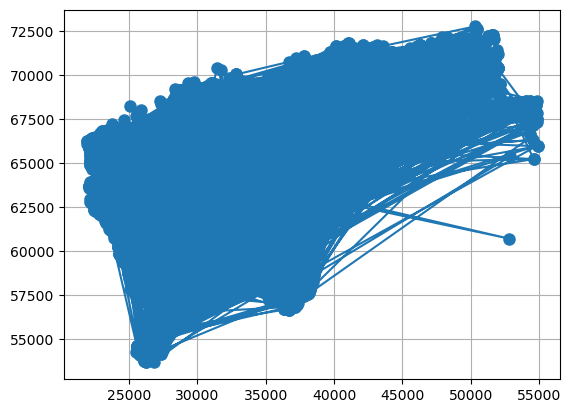

In [150]:
# Testing tabu search for the large dataset

# n = 9152
n, nodes = load_data("C:/Users/Elena/OneDrive - Universitatea Babeş-Bolyai/AI UBB - Semester 4/Metaheuristics/Labs/lab3/input_files/ar9152.tsp")

configuration = tsp_tabu_search(max_iterations, max_memory, n, nodes) # execution time: 6m 46.2s
fitness = tsp_fitness(n, nodes, configuration)

print(f"Solution to TSP for {n} nodes")
print(f"With parameters: max. iterations {max_iterations}, max. memory {max_memory}:")
print(f"Fitness: {fitness}")

print("Route found:")
plot_tsp(nodes, configuration)

## Analysis of the results
- When analysing the **greedy heuristic** for solving the TSP, we see that we find **good solutions**, although with **slight variance**.
  
- In terms of computational requirements, the greedy heuristic, although simple, requires an evaluation of all possible neighbours while advancing, thus making it **computationally complex for large values of n**.
  
- When analysing the **tabu search method** for solving the TSP, we see a significant **increase in solution quality** that comes with increasing the number of maximum iterations.
  
- Both algorithms see a significant increase in execution time as the number of nodes increases.